In [534]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


In [535]:

df = pd.read_csv('updated_dataset (1).csv')


In [536]:
df.columns

Index(['ID', 'Age', 'Gender', 'Race', 'BMI', 'Date of Admission',
       'Date of Hospital Discharge', 'PEG', 'TRACH', 'PEG ORDERS PLACED',
       'TRACH ORDERS PLACED', 'PEG DATE', 'TRACH DATE', 'PEG TIME',
       'TRACH TIME', 'PEG SERVICE', 'TRACH SERVICE', 'Discharge Disposition',
       'Discharge Status Code', 'GCS', 'GCS Qualifier', 'ISS',
       '#CO-MORBIDITIES', 'ICU LOS Days', 'Hospital LOS Days',
       '#Of total complications', 'Date Decannulation', 'Date of oral intake',
       'Date of Death', 'Date of readmission', 'Comorbidities List',
       'Charlson_Comorbidity_Index', 'DischargeGCS', 'VAP',
       'Total_Neutrophils', 'Total_Lymphocytes', 'NLR', 'Skull_Base_Fracture',
       'Skull_Vault_Fracture', 'Hematoma', 'Subdural_Hematoma',
       'Epidural_Hematoma', 'Subpial/Intracerebral_Hemorrhage/Hematoma',
       'Hemorrhage', 'Subarachnoid_Hemorrhage', 'Intraventricular_Hemorrhage',
       'Brain_Edema', 'Contusion_Type', 'Contusion', 'DAI', 'Pneumocephalus',
       

In [537]:
# date columns to datetime
date_columns = ['Date of Admission', 'Date of Hospital Discharge', 'PEG ORDERS PLACED', 'TRACH ORDERS PLACED', 'PEG DATE', 'TRACH DATE', 'Date Decannulation', 'Date of oral intake', 'Date of readmission', 'Date of Death']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Calculate additional parameters
df['PEG_Days_Difference'] = (df['PEG DATE'] - df['PEG ORDERS PLACED']).dt.days
df['TRACH_Days_Difference'] = (df['TRACH DATE'] - df['TRACH ORDERS PLACED']).dt.days
df['Decannulation_Days_Difference'] = (df['Date Decannulation'] - df['TRACH DATE']).dt.days
df['Oral_Intake_Days_Difference'] = (df['Date of oral intake'] - df['PEG DATE']).dt.days
df['PEG_ORDER_to_ADMISSION'] = (df['PEG ORDERS PLACED'] - df['Date of Admission']).dt.days
df['Trach_ORDER_to_ADMISSION'] = (df['TRACH ORDERS PLACED'] - df['Date of Admission']).dt.days

# delta GCS
df['Delta_GCS'] = (df['DischargeGCS'] - df['GCS'])

# Binary prediction column: READMISSION
df['Readmission_Flag'] = df['Date of readmission'].notna().astype(int)

# Binary prediction column: MORTALITY
df['Mortality_Flag'] = df['Date of Death'].notna().astype(int)

# 'Readmission_Flag' is the target variable
target = 'Readmission_Flag'

target2 = 'Mortality_Flag'
# Drop original date columns 
df.drop(columns=['PEG ORDERS PLACED', 'PEG DATE', 'TRACH ORDERS PLACED', 'TRACH DATE', 'Date Decannulation', 'Date of oral intake'], inplace=True)

features = ['Age', 'Gender', 'Race', 'BMI', 'PEG', 'TRACH', 'PEG_Days_Difference', 'TRACH_Days_Difference',
             'Decannulation_Days_Difference', 'Oral_Intake_Days_Difference', 'Discharge Status Code', 'GCS', 
             'ISS', 'ICU LOS Days', 'Hospital LOS Days', 'Charlson_Comorbidity_Index',
               'DischargeGCS', 'VAP', 'NLR', 'Delta_GCS', 'Total_Neutrophils', 'Total_Lymphocytes', 
               'Skull_Base_Fracture', 'Skull_Vault_Fracture', 'Subdural_Hematoma', 'Epidural_Hematoma',
               'Subpial/Intracerebral_Hemorrhage/Hematoma', 'Subarachnoid_Hemorrhage', 'Intraventricular_Hemorrhage',
               'Brain_Edema', 'Contusion', 'DAI', 'Pneumocephalus', 'Cranial_Nerve_Injury', 'Scalp_Injury', 
               'Penetrating_Injury', 'Vascular_Injury/Occlusion', 'Concussions', 'Brain_Stem_Injury'
               ]

X = df[features]

numeric_features = ['BMI', 'PEG_Days_Difference', 'TRACH_Days_Difference',
                     'Decannulation_Days_Difference', 'Oral_Intake_Days_Difference', 
                        'ISS', 'ICU LOS Days', 'Hospital LOS Days', 'Charlson_Comorbidity_Index', 
                       'DischargeGCS', 'NLR', 'Delta_GCS']
binary_features = ['Gender', 'VAP', 'PEG', 'TRACH', 'Skull_Base_Fracture', 'Skull_Vault_Fracture', 
                   'Subdural_Hematoma', 'Epidural_Hematoma',
               'Subpial/Intracerebral_Hemorrhage/Hematoma', 'Subarachnoid_Hemorrhage', 'Intraventricular_Hemorrhage',
               'Contusion', 'DAI', 'Pneumocephalus', 'Cranial_Nerve_Injury', 'Scalp_Injury', 
               'Penetrating_Injury', 'Vascular_Injury/Occlusion', 'Concussions', 'Brain_Stem_Injury']
categorical_features = ['Discharge Status Code', 'Race', 'Brain_Edema']

In [538]:
# Redefine preprocessing pipelines as before
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with the mean
    ('scaler', StandardScaler())  # Standardize numerical features
])

binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))  # Impute missing values with the most frequent value
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with the most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Combine all preprocessors into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('bin', binary_transformer, binary_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply the preprocessing again
X_preprocessed = preprocessor.fit_transform(X)

# Outputting the shape of the processed data to verify the transformation
X_preprocessed.shape



y = df[target]

In [539]:
processed_feature_names = preprocessor.get_feature_names_out()
print(processed_feature_names)

['num__BMI' 'num__PEG_Days_Difference' 'num__TRACH_Days_Difference'
 'num__Decannulation_Days_Difference' 'num__Oral_Intake_Days_Difference'
 'num__ISS' 'num__ICU LOS Days' 'num__Hospital LOS Days'
 'num__Charlson_Comorbidity_Index' 'num__DischargeGCS' 'num__NLR'
 'num__Delta_GCS' 'bin__Gender' 'bin__VAP' 'bin__PEG' 'bin__TRACH'
 'bin__Skull_Base_Fracture' 'bin__Skull_Vault_Fracture'
 'bin__Subdural_Hematoma' 'bin__Epidural_Hematoma'
 'bin__Subpial/Intracerebral_Hemorrhage/Hematoma'
 'bin__Subarachnoid_Hemorrhage' 'bin__Intraventricular_Hemorrhage'
 'bin__Contusion' 'bin__DAI' 'bin__Pneumocephalus'
 'bin__Cranial_Nerve_Injury' 'bin__Scalp_Injury' 'bin__Penetrating_Injury'
 'bin__Vascular_Injury/Occlusion' 'bin__Concussions'
 'bin__Brain_Stem_Injury' 'cat__Discharge Status Code_1'
 'cat__Discharge Status Code_2' 'cat__Discharge Status Code_3'
 'cat__Discharge Status Code_6' 'cat__Discharge Status Code_7'
 'cat__Discharge Status Code_20' 'cat__Discharge Status Code_50'
 'cat__Discharge S

In [540]:
X_preprocessed.shape

(263, 50)

In [541]:
df.dtypes

ID                            int64
Age                           int64
Gender                        int64
Race                         object
BMI                         float64
                             ...   
PEG_ORDER_to_ADMISSION      float64
Trach_ORDER_to_ADMISSION    float64
Delta_GCS                     int64
Readmission_Flag              int32
Mortality_Flag                int32
Length: 62, dtype: object

In [542]:
readmission_counts = df['Readmission_Flag'].value_counts()
print(readmission_counts)

Readmission_Flag
0    150
1    113
Name: count, dtype: int64


________    

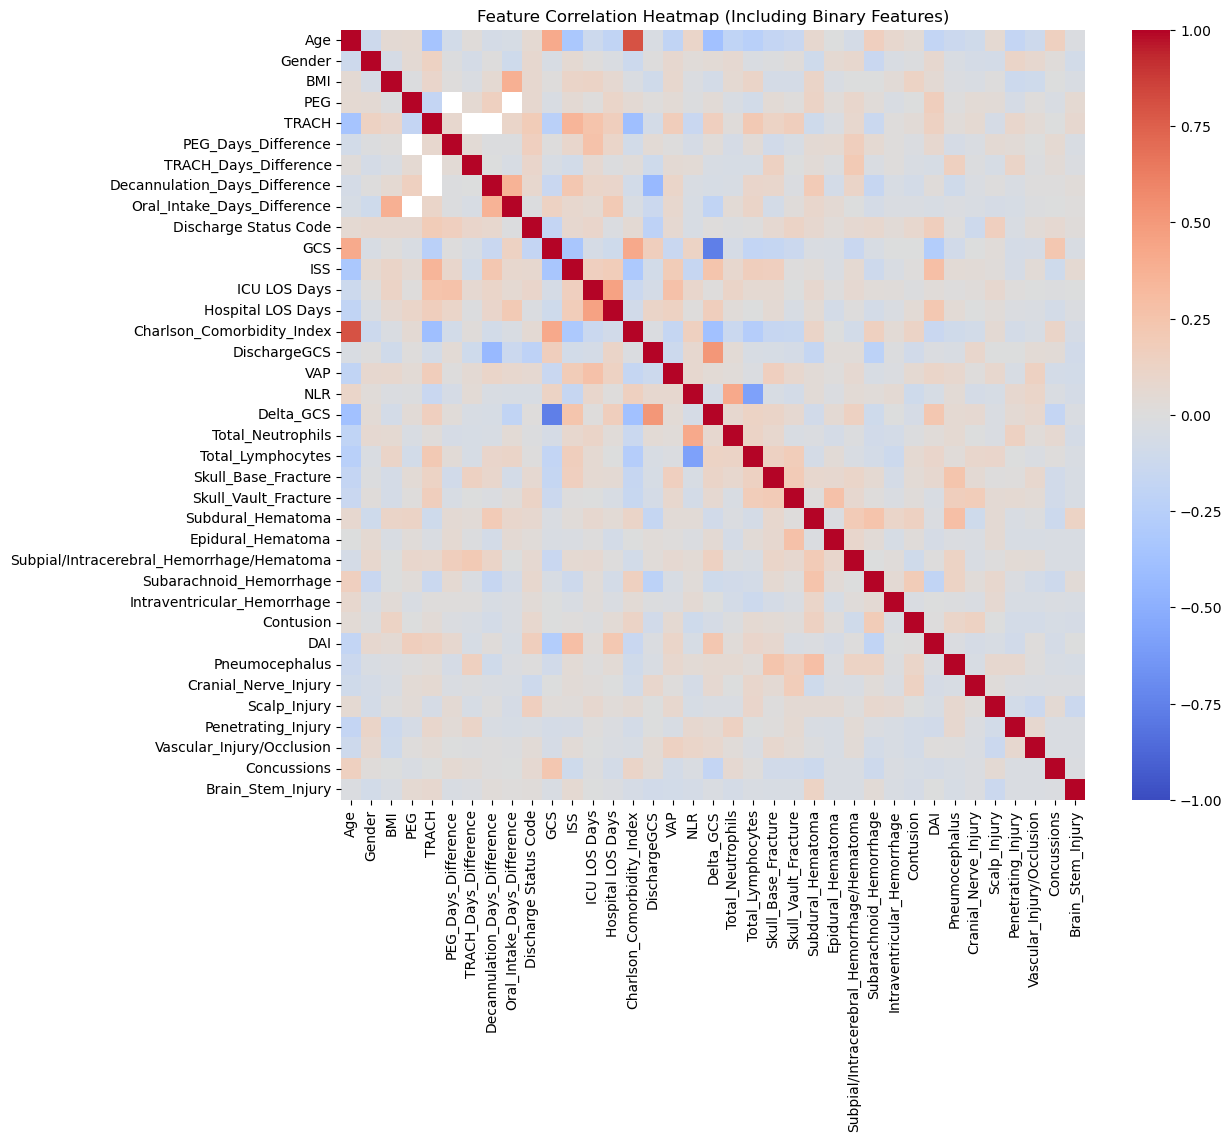

In [543]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric and binary columns for correlation analysis
# Assuming binary features are stored as 0/1 in the DataFrame
numeric_binary_df = X.select_dtypes(include=[np.number])

# Compute the Pearson correlation matrix
correlation_matrix = numeric_binary_df.corr()

# Plot the heatmap of correlations
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap (Including Binary Features)")
plt.show()


In [544]:
# Find pairs of features with correlation greater than 0.6
correlated_pairs = []
threshold = 0.6

for i in range(correlation_matrix.shape[0]):
    for j in range(i + 1, correlation_matrix.shape[1]):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            correlated_pairs.append((correlation_matrix.index[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

# Display highly correlated feature pairs
correlated_pairs_df = pd.DataFrame(correlated_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])
correlated_pairs_df.sort_values(by='Correlation', ascending=False, inplace=True)

# Show correlated pairs
print("Highly correlated features (|correlation| > 0.6):")
correlated_pairs_df

Highly correlated features (|correlation| > 0.6):


,Feature 1,Feature 2,Correlation
0,Age,Charlson_Comorbidity_Index,0.797348
1,GCS,Delta_GCS,-0.760425


## UL

In [545]:
import umap

# Apply preprocessing to the dataset
X_preprocessed = preprocessor.fit_transform(df)

# Apply UMAP for dimensionality reduction
umap_reducer = umap.UMAP(n_neighbors=20, n_components=3, metric='cosine', min_dist=0.20, random_state=42)
X_umap = umap_reducer.fit_transform(X_preprocessed)


# Check the shape of the reduced dataset
print("Shape of UMAP-reduced data:", X_umap.shape)

c:\Users\shrin\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\shrin\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Shape of UMAP-reduced data: (263, 3)


Optimal Number of Clusters: 3
Optimal Linkage Method: complete
Optimal Distance Metric: cosine
Silhouette Score: 0.5802876949310303


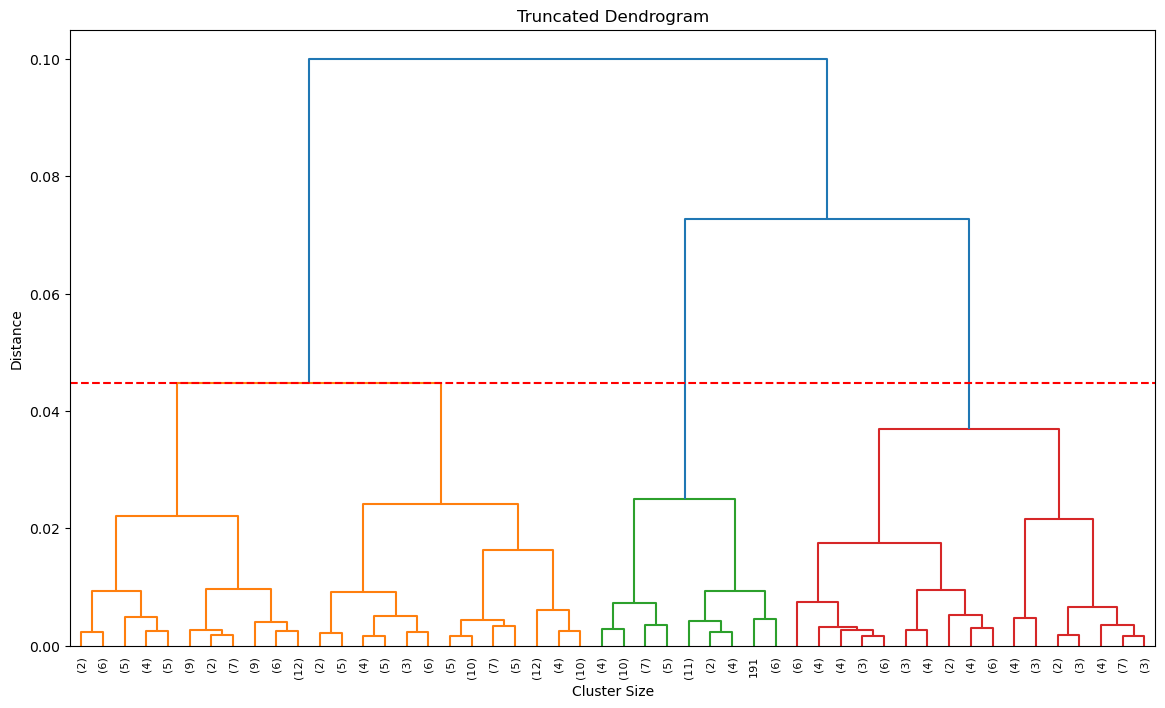

In [546]:
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from scipy.spatial import ConvexHull

# Optimal parameters
optimal_clusters = 3
optimal_linkage = 'complete'
optimal_distance = 'cosine'

# Perform Agglomerative Clustering 
clustering = AgglomerativeClustering(n_clusters=optimal_clusters, linkage=optimal_linkage, metric=optimal_distance)
cluster_labels_Agglomerative = clustering.fit_predict(X_umap)

# Map cluster labels from 0, 1, 2 to A, B, C
label_mapping = {0: 'A', 1: 'B', 2: 'C'}
cluster_labels_Agglomerative = pd.Series(cluster_labels_Agglomerative).map(label_mapping)

# silhouette score
silhouette_avg = silhouette_score(X_umap, cluster_labels_Agglomerative, metric=optimal_distance)

print(f"Optimal Number of Clusters: {optimal_clusters}")
print(f"Optimal Linkage Method: {optimal_linkage}")
print(f"Optimal Distance Metric: {optimal_distance}")
print(f"Silhouette Score: {silhouette_avg}")

# 3D Plot using Plotly
fig = px.scatter_3d(
    x=X_umap[:, 0], 
    y=X_umap[:, 1], 
    z=X_umap[:, 2], 
    color=cluster_labels_Agglomerative, 
    title='Agglomerative Clustering',
    labels={'x': 'UMAP Component 1', 'y': 'UMAP Component 2', 'z': 'UMAP Component 3'},
    color_continuous_scale=px.colors.sequential.Viridis,
    opacity=0.6,  # Reduce the opacity of the instances
    size_max=3  # Reduce the size of the instances
)

# Add convex hulls
colors = px.colors.sequential.Viridis
for i, label in enumerate(label_mapping.values()):
    points = X_umap[cluster_labels_Agglomerative == label]
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]
    fig.add_trace(go.Mesh3d(
        x=hull_points[:, 0],
        y=hull_points[:, 1],
        z=hull_points[:, 2],
        opacity=0.2,
        color=colors[i % len(colors)],  # Use the same color as the cluster
        alphahull=0
    ))

# Increase the size of the overall plot
fig.update_layout(
    width=1200,
    height=1200
)

fig.show()

import scipy.cluster.hierarchy as sch

# Perform hierarchical/agglomerative clustering thru linkage
Z = linkage(X_umap, method=optimal_linkage, metric=optimal_distance)

# Plot a truncated dendrogram, only showing the last p merged clusters
plt.figure(figsize=(14, 8))
dendrogram = sch.dendrogram(Z, truncate_mode='lastp', p=50)  # Adjust p as needed
plt.axhline(y=Z[-optimal_clusters, 2], color='r', linestyle='--')  # Draw a red line at the determined number of clusters
plt.title('Truncated Dendrogram')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()


In [547]:


feature_names = [f'Feature_{i}' for i in range(X.shape[1])]
X_df = pd.DataFrame(X, columns=feature_names)

# Cluster labelling
X_df['Cluster_Labels_Agglomerative'] = cluster_labels_Agglomerative
from scipy.stats import ttest_ind

df['Cluster_Labels_Agglomerative'] = cluster_labels_Agglomerative


# distribution of the target variable across clusters
for i in range(optimal_clusters):
    cluster_group = df[df['Cluster_Labels_Agglomerative'] == i][target]
    rest_of_data = df[df['Cluster_Labels_Agglomerative'] != i][target]
    t_stat, p_val = ttest_ind(cluster_group, rest_of_data, equal_var=False)
    print(f"Cluster {i} vs Rest: t-statistic = {t_stat}, p-value = {p_val}")




Cluster 0 vs Rest: t-statistic = nan, p-value = nan
Cluster 1 vs Rest: t-statistic = nan, p-value = nan
Cluster 2 vs Rest: t-statistic = nan, p-value = nan


In [548]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
import numpy as np

# Define features and target
y = df[target]  # Readmission_Flag as target
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=preprocessor.get_feature_names_out())

# Compute Mutual Information
mutual_info = mutual_info_classif(X_preprocessed_df, y, random_state=42)

# Create a DataFrame for better readability
mutual_info_df = pd.DataFrame({
    'Feature': X_preprocessed_df.columns,
    'Mutual Information': mutual_info
}).sort_values(by='Mutual Information', ascending=False)

# Display top features
print("Top Features by Mutual Information:")
print(mutual_info_df.head(30))


Top Features by Mutual Information:
                             Feature  Mutual Information
31            bin__Brain_Stem_Injury            0.094578
4   num__Oral_Intake_Days_Difference            0.068532
49           cat__Brain_Edema_Severe            0.062517
39     cat__Discharge Status Code_62            0.059174
5                           num__ISS            0.049530
11                    num__Delta_GCS            0.047207
34      cat__Discharge Status Code_3            0.042772
48         cat__Brain_Edema_Moderate            0.038568
35      cat__Discharge Status Code_6            0.036645
37     cat__Discharge Status Code_20            0.032860
45                   cat__Race_OTHER            0.031947
13                          bin__VAP            0.031487
9                  num__DischargeGCS            0.029658
21      bin__Subarachnoid_Hemorrhage            0.024832
28           bin__Penetrating_Injury            0.022002
47             cat__Brain_Edema_Mild            0.01

In [549]:
cluster_counts = df['Cluster_Labels_Agglomerative'].value_counts()
print(cluster_counts)


Cluster_Labels_Agglomerative
A    145
B     68
C     50
Name: count, dtype: int64


### Cool Clusters

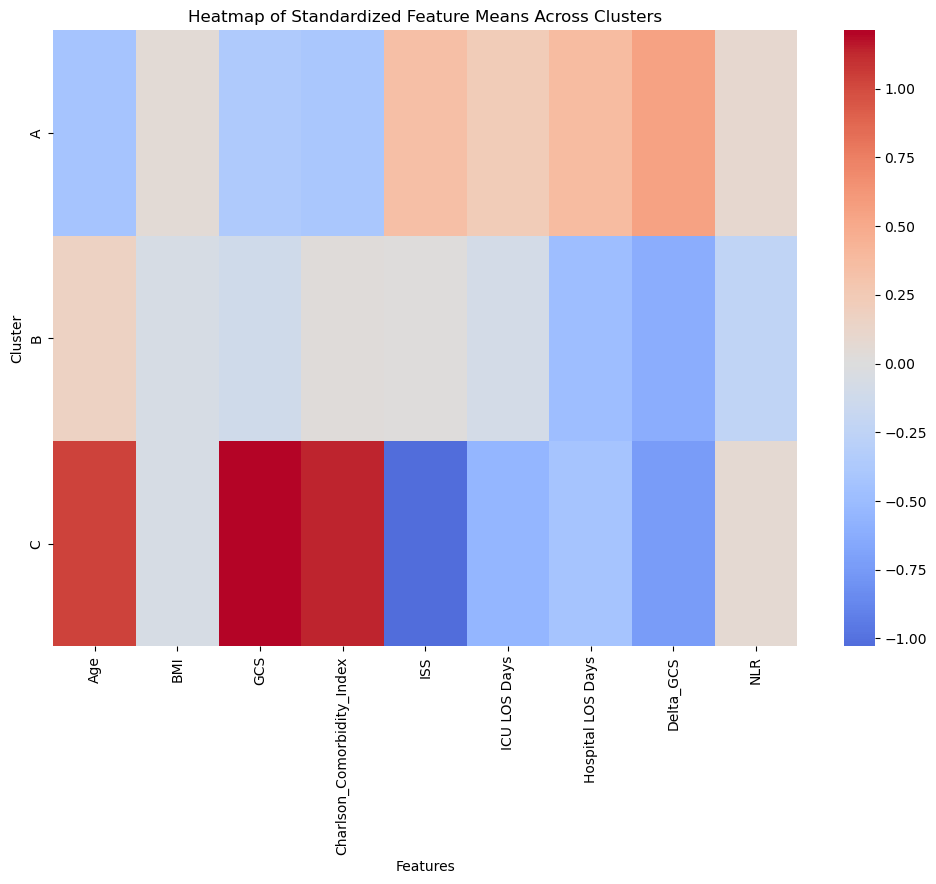

In [550]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

features_to_evaluate = ['Age', 'BMI', 'GCS','Charlson_Comorbidity_Index', 'ISS', 'ICU LOS Days', 
                        'Hospital LOS Days', 'Delta_GCS', 'NLR']

# Standardize 
scaler = StandardScaler()
df_standardized = df.copy()
df_standardized[features_to_evaluate] = scaler.fit_transform(df[features_to_evaluate])

cluster_means = df_standardized.groupby('Cluster_Labels_Agglomerative')[features_to_evaluate].mean()

# heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means, annot=False, cmap='coolwarm', center=0)
plt.title('Heatmap of Standardized Feature Means Across Clusters')
plt.xlabel('Features')
plt.ylabel('Cluster')
plt.show()


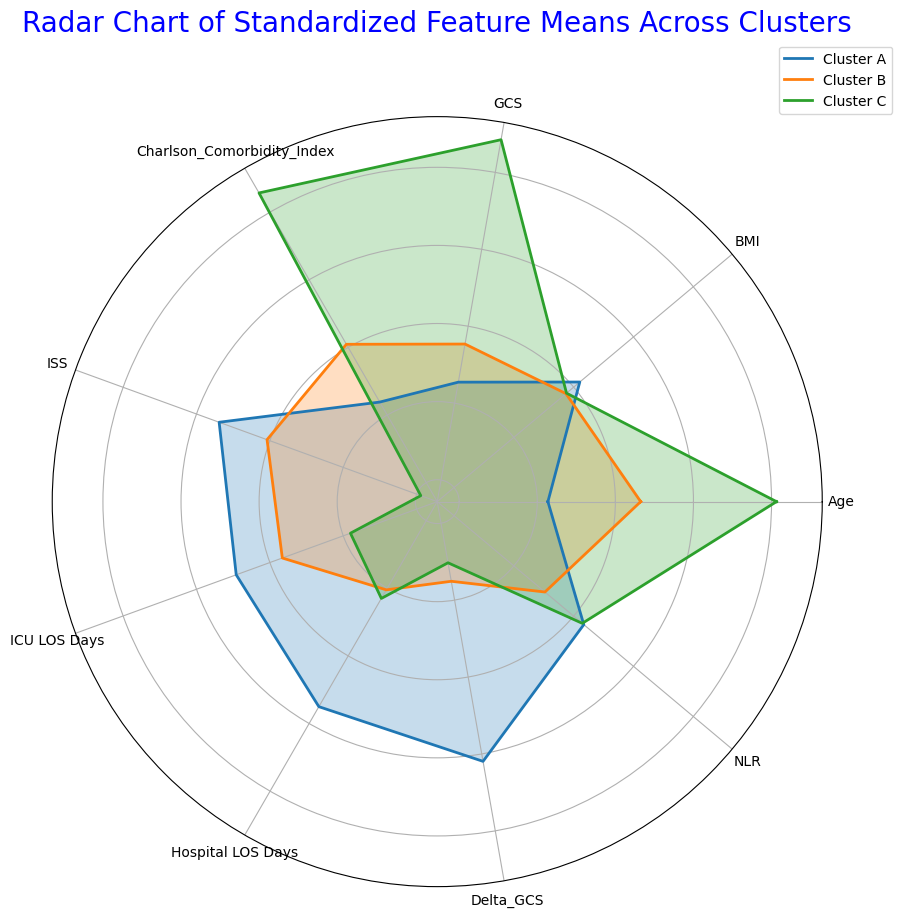

In [551]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Mean of each feature per cluster
cluster_means = df_standardized.groupby('Cluster_Labels_Agglomerative')[features_to_evaluate].mean()

# Radar Chart
labels = features_to_evaluate
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

for i, row in cluster_means.iterrows():
    values = row.tolist()
    values += values[:1]  # Complete the loop
    ax.plot(angles, values, linewidth=2, label=f'Cluster {i}')
    ax.fill(angles, values, alpha=0.25)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

ax.set_yticklabels([])

plt.title('Radar Chart of Standardized Feature Means Across Clusters', size=20, color='blue', y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

plt.show()


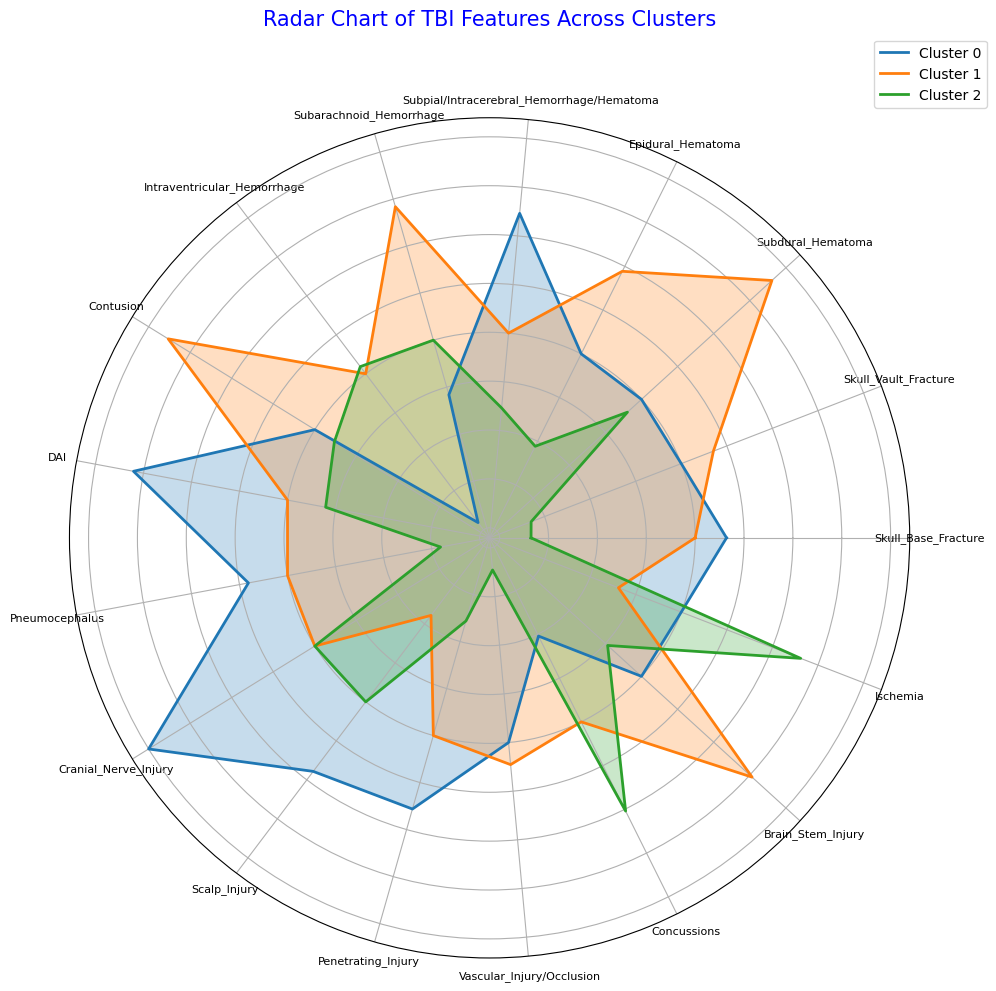

In [552]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

TBI_features = ['Skull_Base_Fracture', 'Skull_Vault_Fracture',
    'Subdural_Hematoma', 'Epidural_Hematoma',
    'Subpial/Intracerebral_Hemorrhage/Hematoma',
    'Subarachnoid_Hemorrhage', 'Intraventricular_Hemorrhage',
    'Contusion', 'DAI', 'Pneumocephalus',
    'Cranial_Nerve_Injury', 'Scalp_Injury',
    'Penetrating_Injury', 'Vascular_Injury/Occlusion', 'Concussions',
    'Brain_Stem_Injury', 'Ischemia'
         ]

# Ensure TBI_features are binary or numeric
for feature in TBI_features:
    if not pd.api.types.is_numeric_dtype(df_standardized[feature]):
     df_standardized[feature] = df_standardized[feature].astype('category').cat.codes  # Convert to numeric if not already

# Mean of each feature per cluster
cluster_means_binary = df_standardized.groupby('Cluster_Labels_Agglomerative')[TBI_features].mean()  # Proportion for binary features

# Standardize the means to 0-1 range
scaler = RobustScaler()
cluster_means_binary_scaled = pd.DataFrame(scaler.fit_transform(cluster_means_binary), columns=cluster_means_binary.columns)

# Radar Chart
labels = TBI_features
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

for i, row in cluster_means_binary_scaled.iterrows():
    values = row.tolist()
    values += values[:1]  # Complete the loop
    ax.plot(angles, values, linewidth=2, label=f'Cluster {i}')
    ax.fill(angles, values, alpha=0.25)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=8)

ax.set_yticklabels([])

plt.title('Radar Chart of TBI Features Across Clusters', size=15, color='blue', y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1), fontsize=10)
plt.tight_layout()
plt.show()


Chi-square Test Results for TBI Features Across Clusters:
                                                P-value  Significant
DAI                                        1.630772e-07         True
Subarachnoid_Hemorrhage                    1.771104e-05         True
Skull_Base_Fracture                        1.468705e-02         True
Concussions                                2.118769e-02         True
Contusion                                  2.177679e-02         True
Skull_Vault_Fracture                       3.624801e-02         True
Brain_Stem_Injury                          5.925351e-02        False
Pneumocephalus                             1.031513e-01        False
Cranial_Nerve_Injury                       1.915277e-01        False
Subdural_Hematoma                          1.965327e-01        False
Subpial/Intracerebral_Hemorrhage/Hematoma  2.218333e-01        False
Penetrating_Injury                         2.610659e-01        False
Epidural_Hematoma                          4.

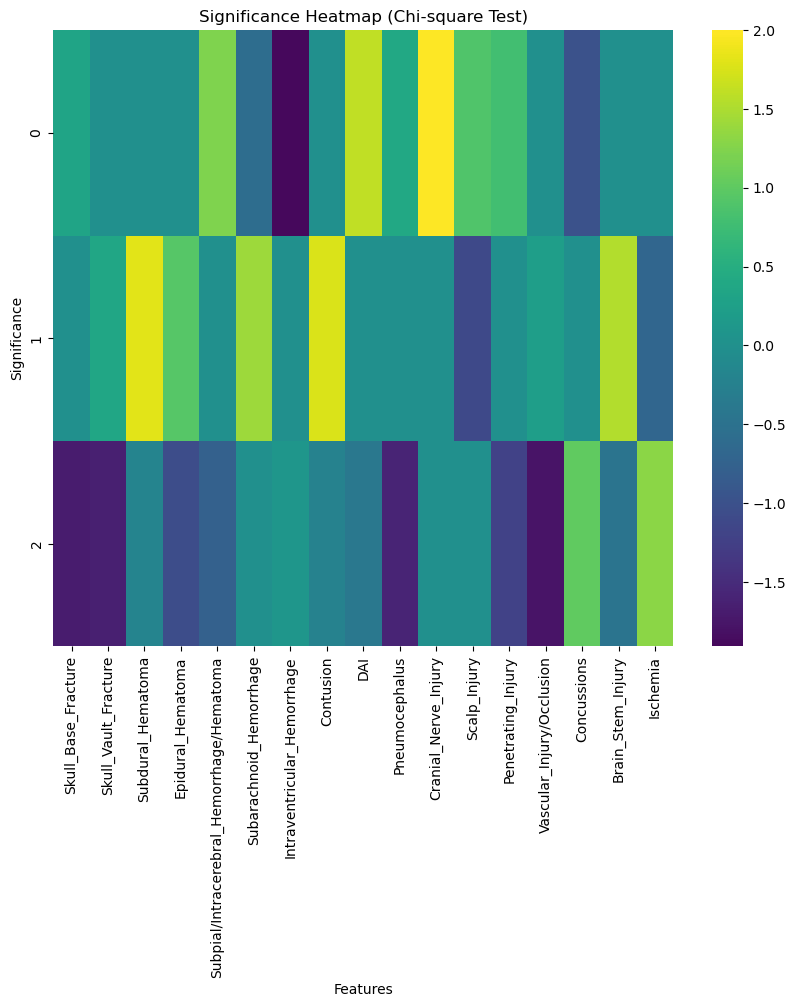

In [553]:
from scipy.stats import chi2_contingency
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize a dictionary to store p-values for each feature
chi2_results = {}

for feature in TBI_features:
    # Create a contingency table for the feature vs clusters
    contingency_table = pd.crosstab(df[feature], df['Cluster_Labels_Agglomerative'])
    
    # Perform the Chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Store the p-value
    chi2_results[feature] = p

# Convert the results to a DataFrame
chi2_results_df = pd.DataFrame.from_dict(chi2_results, orient='index', columns=['P-value'])
chi2_results_df.sort_values(by='P-value', inplace=True)

# Add a significance column
chi2_results_df['Significant'] = chi2_results_df['P-value'] < 0.05

# Display the results
print("Chi-square Test Results for TBI Features Across Clusters:")
print(chi2_results_df)

# Plot heatmap of significant features
plt.figure(figsize=(10, 8))
sns.heatmap(cluster_means_binary_scaled, annot=False, cmap='viridis', center=0)
plt.title('Significance Heatmap (Chi-square Test)')
plt.xlabel('Features')
plt.ylabel('Significance')
plt.show()


_____________________

### Analysis

In [554]:
# Calculate days to readmission
df['Days_to_Readmission'] = (df['Date of readmission'] - df['Date of Hospital Discharge']).dt.days
df['Days_to_Readmission'] = df['Days_to_Readmission'].fillna(float('inf'))  # Mark as infinity for patients not readmitted
# Create new binary target variables based on `Days_to_Readmission`
df['7_day_Readmission'] = (df['Days_to_Readmission'] <= 7).astype(int)
df['30_day_Readmission'] = (df['Days_to_Readmission'] <= 30).astype(int)
df['90_day_Readmission'] = (df['Days_to_Readmission'] <= 90).astype(int)
df['365_day_Readmission'] = (df['Days_to_Readmission'] <= 365).astype(int)



# 'Readmission_Flag' is the target variable
target = 'Readmission_Flag'
Seven_day_target = '7_day_Readmission'
Thirty_day_target = '30_day_Readmission'
Ninety_day_target = '90_day_Readmission'
ThreeSixtyFive_day_target = '365_day_Readmission'

# Calculate days to readmission
df['Days_to_Mortality'] = (df['Date of Death'] - df['Date of Admission']).dt.days
df['Days_to_Mortality'] = df['Days_to_Mortality'].fillna(float('inf'))  # Mark as infinity for patients not readmitted
# Create new binary target variables based on `Days_to_Readmission`
df['7_day_Mortality'] = (df['Days_to_Mortality'] <= 7).astype(int)
df['30_day_Mortality'] = (df['Days_to_Mortality'] <= 30).astype(int)
df['90_day_Mortality'] = (df['Days_to_Mortality'] <= 90).astype(int)
df['365_day_Mortality'] = (df['Days_to_Mortality'] <= 365).astype(int)



Seven_day_target2 = '7_day_Mortality'
Thirty_day_target2 = '30_day_Mortality'
Ninety_day_target2 = '90_day_Mortality'
ThreeSixtyFive_day_target2 = '365_day_Mortality'

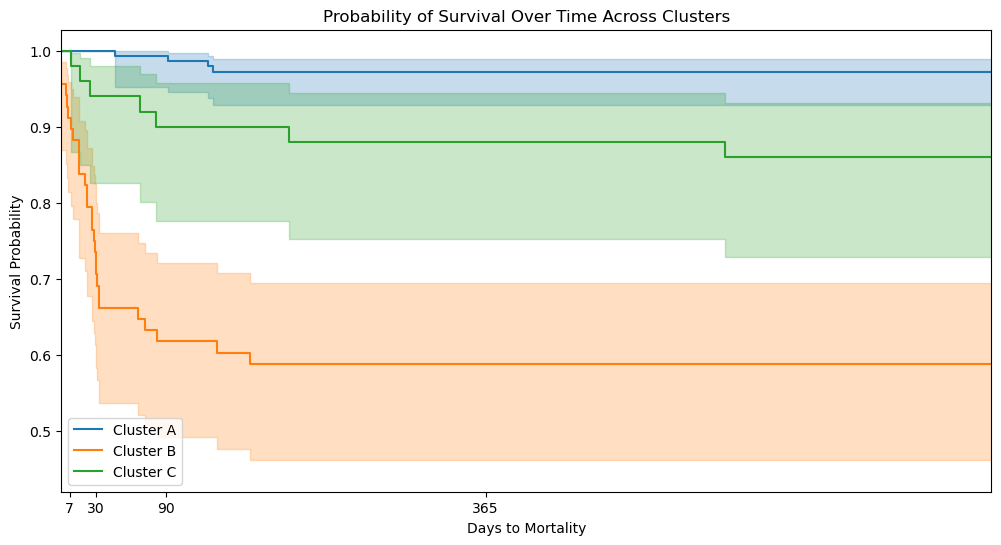

Log-rank test between Cluster A and Cluster B: p-value = 0.0000
Log-rank test between Cluster A and Cluster C: p-value = 0.0061
Log-rank test between Cluster B and Cluster C: p-value = 0.0007


In [555]:
from lifelines import KaplanMeierFitter
import numpy as np

max_follow_up = df['Days_to_Mortality'][df['Days_to_Mortality'] != float('inf')].max()
df['Days_to_Mortality'] = df['Days_to_Mortality'].replace(float('inf'), max_follow_up)

kmf = KaplanMeierFitter()

# For each cluster, plot the survival curve
plt.figure(figsize=(12, 6))
for label in df['Cluster_Labels_Agglomerative'].unique():
    kmf.fit(durations=df[df['Cluster_Labels_Agglomerative'] == label]['Days_to_Mortality'],
            event_observed=df[df['Cluster_Labels_Agglomerative'] == label]['Mortality_Flag'])
    kmf.plot(label=f'Cluster {label}')

# Customize x-axis ticks and add space on the right side
plt.xticks([7, 30, 90, 365], ['7', '30', '90', '365'])
plt.xlim(0, 800)  # Extend the x-axis limit to add space
plt.title('Probability of Survival Over Time Across Clusters')
plt.xlabel('Days to Mortality')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

from lifelines.statistics import logrank_test

#  log-rank test between each pair of clusters
for i in df['Cluster_Labels_Agglomerative'].unique():
    for j in df['Cluster_Labels_Agglomerative'].unique():
        if i < j:
            group_i = df[df['Cluster_Labels_Agglomerative'] == i]
            group_j = df[df['Cluster_Labels_Agglomerative'] == j]
            
            if not group_j.empty:
                result = logrank_test(
                    group_i['Days_to_Mortality'], group_j['Days_to_Mortality'],
                    event_observed_A=group_i['Mortality_Flag'], event_observed_B=group_j['Mortality_Flag']
                )
                
                print(f"Log-rank test between Cluster {i} and Cluster {j}: p-value = {result.p_value:.4f}")


In [556]:
import pandas as pd
from scipy.stats import chi2_contingency

# Calculate the percentage of Readmission_Flag in each cluster
cluster_mortality = df.groupby('Cluster_Labels_Agglomerative')['Mortality_Flag'].agg(['mean', 'sum', 'count'])
cluster_mortality['Percentage'] = cluster_mortality['mean'] * 100

# Print percentages
print("Percentage of cluster_mortality in each cluster:")
print(cluster_mortality[['Percentage']])

# Prepare a contingency table for the chi-squared test
contingency_table = pd.crosstab(df['Cluster_Labels_Agglomerative'], df['Mortality_Flag'])

# Perform the chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the p-value
print("\nChi-squared Test Results:")
print(f"Chi-squared statistic: {chi2}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p}")

# Interpretation
if p < 0.05:
    print("The differences in Readmission_Flag proportions across clusters are statistically significant.")
else:
    print("The differences in Readmission_Flag proportions across clusters are not statistically significant.")

# Group by cluster and calculate the percentage of Readmission_Flag in each cluster
mortality_percentages_7 = df.groupby('Cluster_Labels_Agglomerative')['7_day_Mortality'].mean() * 100
mortality_percentages_30 = df.groupby('Cluster_Labels_Agglomerative')['30_day_Mortality'].mean() * 100
mortality_percentages_90 = df.groupby('Cluster_Labels_Agglomerative')['90_day_Mortality'].mean() * 100
mortality_percentages_365 = df.groupby('Cluster_Labels_Agglomerative')['365_day_Mortality'].mean() * 100

# Display the percentages
print("Percentage of 7-day readmission in each cluster:")
print(mortality_percentages_7)

print("\nPercentage of 30-day readmission in each cluster:")
print(mortality_percentages_30)

print("\nPercentage of 90-day readmission in each cluster:")
print(mortality_percentages_90)

print("\nPercentage of 365-day readmission in each cluster:")
print(mortality_percentages_365)

Percentage of cluster_mortality in each cluster:
                              Percentage
Cluster_Labels_Agglomerative            
A                               3.448276
B                              42.647059
C                              14.000000

Chi-squared Test Results:
Chi-squared statistic: 54.17118095659604
Degrees of freedom: 2
P-value: 1.725351223580017e-12
The differences in Readmission_Flag proportions across clusters are statistically significant.
Percentage of 7-day readmission in each cluster:
Cluster_Labels_Agglomerative
A    0.000000
B    8.823529
C    0.000000
Name: 7_day_Mortality, dtype: float64

Percentage of 30-day readmission in each cluster:
Cluster_Labels_Agglomerative
A     0.000000
B    29.411765
C     6.000000
Name: 30_day_Mortality, dtype: float64

Percentage of 90-day readmission in each cluster:
Cluster_Labels_Agglomerative
A     0.689655
B    38.235294
C    10.000000
Name: 90_day_Mortality, dtype: float64

Percentage of 365-day readmission in each c

In [557]:
import pandas as pd
from scipy.stats import chi2_contingency

# Prepare contingency tables and perform chi-squared tests for each timeframe
timeframes = ['7_day_Mortality', '30_day_Mortality', '90_day_Mortality', '365_day_Mortality']

# Iterate through each timeframe
for timeframe in timeframes:
    print(f"\nAnalyzing {timeframe}...")

    # Prepare a contingency table
    contingency_table = pd.crosstab(df['Cluster_Labels_Agglomerative'], df[timeframe])

    # Perform the chi-squared test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Print the results
    print("Contingency Table:")
    print(contingency_table)
    print(f"Chi-squared statistic: {chi2:.4f}")
    print(f"Degrees of freedom: {dof}")
    print(f"P-value: {p:.4f}")

    # Interpretation
    if p < 0.05:
        print(f"The differences in {timeframe} proportions across clusters are statistically significant.")
    else:
        print(f"The differences in {timeframe} proportions across clusters are not statistically significant.")



Analyzing 7_day_Mortality...
Contingency Table:
7_day_Mortality                 0  1
Cluster_Labels_Agglomerative        
A                             145  0
B                              62  6
C                              50  0
Chi-squared statistic: 17.6076
Degrees of freedom: 2
P-value: 0.0002
The differences in 7_day_Mortality proportions across clusters are statistically significant.

Analyzing 30_day_Mortality...
Contingency Table:
30_day_Mortality                0   1
Cluster_Labels_Agglomerative         
A                             145   0
B                              48  20
C                              47   3
Chi-squared statistic: 50.7608
Degrees of freedom: 2
P-value: 0.0000
The differences in 30_day_Mortality proportions across clusters are statistically significant.

Analyzing 90_day_Mortality...
Contingency Table:
90_day_Mortality                0   1
Cluster_Labels_Agglomerative         
A                             144   1
B                              42  

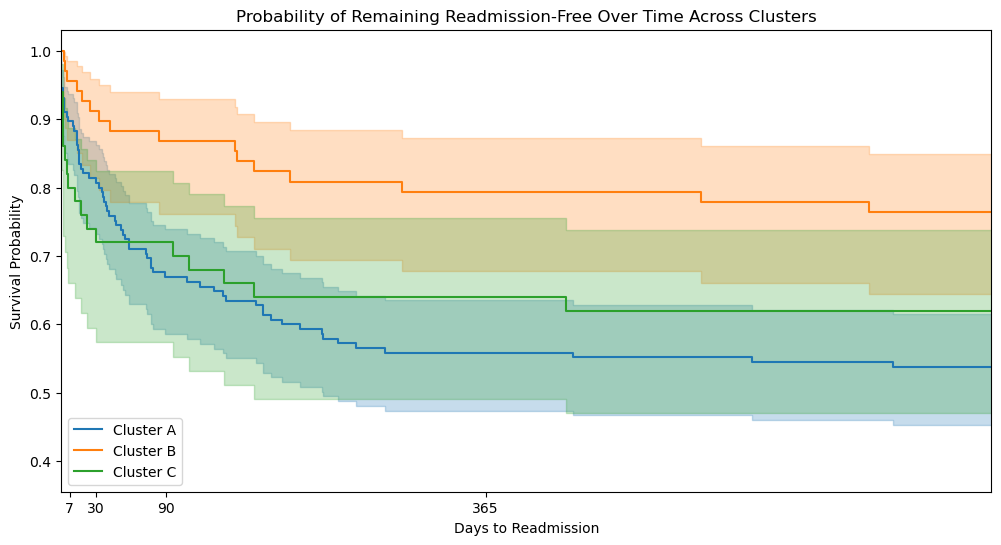

In [558]:
from lifelines import KaplanMeierFitter
import numpy as np

max_follow_up = df['Days_to_Readmission'][df['Days_to_Readmission'] != float('inf')].max()
df['Days_to_Readmission'] = df['Days_to_Readmission'].replace(float('inf'), max_follow_up)

kmf = KaplanMeierFitter()

# For each cluster, plot the survival curve
plt.figure(figsize=(12, 6))
for i in df['Cluster_Labels_Agglomerative'].unique():
    kmf.fit(durations=df[df['Cluster_Labels_Agglomerative'] == i]['Days_to_Readmission'],
            event_observed=df[df['Cluster_Labels_Agglomerative'] == i]['Readmission_Flag'])
    kmf.plot(label=f'Cluster {i}')

plt.xticks([7, 30, 90, 365], ['7', '30', '90', '365'])
plt.xlim(0, 800)
plt.title('Probability of Remaining Readmission-Free Over Time Across Clusters')
plt.xlabel('Days to Readmission')
plt.ylabel('Survival Probability')
plt.legend(loc='lower left', bbox_to_anchor=(0, 0))
plt.show()


In [559]:
from lifelines.statistics import logrank_test

# Define the cluster labels
cluster_labels = ['A', 'B', 'C']

# Log-rank test between each pair of clusters
for i in range(len(cluster_labels)):
    for j in range(i + 1, len(cluster_labels)):
        group_i = df[df['Cluster_Labels_Agglomerative'] == cluster_labels[i]]
        group_j = df[df['Cluster_Labels_Agglomerative'] == cluster_labels[j]]
        
        result = logrank_test(
            group_i['Days_to_Readmission'], group_j['Days_to_Readmission'],
            event_observed_A=group_i['Readmission_Flag'], event_observed_B=group_j['Readmission_Flag']
        )
        
        print(f"Log-rank test between Cluster {cluster_labels[i]} and Cluster {cluster_labels[j]}: p-value = {result.p_value:.4f}")


Log-rank test between Cluster A and Cluster B: p-value = 0.0002
Log-rank test between Cluster A and Cluster C: p-value = 0.1754
Log-rank test between Cluster B and Cluster C: p-value = 0.0710


In [560]:
import pandas as pd
from scipy.stats import chi2_contingency

# Calculate the percentage of Readmission_Flag in each cluster
cluster_readmission = df.groupby('Cluster_Labels_Agglomerative')['Readmission_Flag'].agg(['mean', 'sum', 'count'])
cluster_readmission['Percentage'] = cluster_readmission['mean'] * 100

# Print percentages
print("Percentage of Readmission_Flag in each cluster:")
print(cluster_readmission[['Percentage']])

# Prepare a contingency table for the chi-squared test
contingency_table = pd.crosstab(df['Cluster_Labels_Agglomerative'], df['Readmission_Flag'])

# Perform the chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the p-value
print("\nChi-squared Test Results:")
print(f"Chi-squared statistic: {chi2}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p}")

# Interpretation
if p < 0.05:
    print("The differences in Readmission_Flag proportions across clusters are statistically significant.")
else:
    print("The differences in Readmission_Flag proportions across clusters are not statistically significant.")


Percentage of Readmission_Flag in each cluster:
                              Percentage
Cluster_Labels_Agglomerative            
A                              53.103448
B                              25.000000
C                              38.000000

Chi-squared Test Results:
Chi-squared statistic: 15.54088428440647
Degrees of freedom: 2
P-value: 0.00042202662976814485
The differences in Readmission_Flag proportions across clusters are statistically significant.


In [561]:
# Group by cluster and calculate the percentage of Readmission_Flag in each cluster
readmission_percentages_7 = df.groupby('Cluster_Labels_Agglomerative')['7_day_Readmission'].mean() * 100
readmission_percentages_30 = df.groupby('Cluster_Labels_Agglomerative')['30_day_Readmission'].mean() * 100
readmission_percentages_90 = df.groupby('Cluster_Labels_Agglomerative')['90_day_Readmission'].mean() * 100
readmission_percentages_365 = df.groupby('Cluster_Labels_Agglomerative')['365_day_Readmission'].mean() * 100

# Display the percentages
print("Percentage of 7-day readmission in each cluster:")
print(readmission_percentages_7)

print("\nPercentage of 30-day readmission in each cluster:")
print(readmission_percentages_30)

print("\nPercentage of 90-day readmission in each cluster:")
print(readmission_percentages_90)

print("\nPercentage of 365-day readmission in each cluster:")
print(readmission_percentages_365)

Percentage of 7-day readmission in each cluster:
Cluster_Labels_Agglomerative
A    10.344828
B     4.411765
C    20.000000
Name: 7_day_Readmission, dtype: float64

Percentage of 30-day readmission in each cluster:
Cluster_Labels_Agglomerative
A    19.310345
B     8.823529
C    28.000000
Name: 30_day_Readmission, dtype: float64

Percentage of 90-day readmission in each cluster:
Cluster_Labels_Agglomerative
A    33.103448
B    13.235294
C    28.000000
Name: 90_day_Readmission, dtype: float64

Percentage of 365-day readmission in each cluster:
Cluster_Labels_Agglomerative
A    44.137931
B    20.588235
C    36.000000
Name: 365_day_Readmission, dtype: float64


In [562]:
import pandas as pd
from scipy.stats import chi2_contingency

# Prepare contingency tables and perform chi-squared tests for each timeframe
timeframes = ['7_day_Readmission', '30_day_Readmission', '90_day_Readmission', '365_day_Readmission']

# Iterate through each timeframe
for timeframe in timeframes:
    print(f"\nAnalyzing {timeframe}...")

    # Prepare a contingency table
    contingency_table = pd.crosstab(df['Cluster_Labels_Agglomerative'], df[timeframe])

    # Perform the chi-squared test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Print the results
    print("Contingency Table:")
    print(contingency_table)
    print(f"Chi-squared statistic: {chi2:.4f}")
    print(f"Degrees of freedom: {dof}")
    print(f"P-value: {p:.4f}")

    # Interpretation
    if p < 0.05:
        print(f"The differences in {timeframe} proportions across clusters are statistically significant.")
    else:
        print(f"The differences in {timeframe} proportions across clusters are not statistically significant.")



Analyzing 7_day_Readmission...
Contingency Table:
7_day_Readmission               0   1
Cluster_Labels_Agglomerative         
A                             130  15
B                              65   3
C                              40  10
Chi-squared statistic: 7.3909
Degrees of freedom: 2
P-value: 0.0248
The differences in 7_day_Readmission proportions across clusters are statistically significant.

Analyzing 30_day_Readmission...
Contingency Table:
30_day_Readmission              0   1
Cluster_Labels_Agglomerative         
A                             117  28
B                              62   6
C                              36  14
Chi-squared statistic: 7.3449
Degrees of freedom: 2
P-value: 0.0254
The differences in 30_day_Readmission proportions across clusters are statistically significant.

Analyzing 90_day_Readmission...
Contingency Table:
90_day_Readmission             0   1
Cluster_Labels_Agglomerative        
A                             97  48
B                        

___________________________________